In [1]:
import pandas as pd
from datetime import date

import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.pipeline import Pipeline

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)

# Parameter Tuning

Exhaustive search over specified parameter values for an estimator, tuning the models.

### Getting data

In [2]:
train_data = pd.read_pickle("train_data.pkl")
test_data = pd.read_pickle("test_data.pkl")

features = list(train_data.columns)
features.remove('status')
features.remove('loan_id')

label = 'status'

x = train_data[features]
y = train_data[label]

### Train Test Split

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

### Normalization

Some of the algorithms we plan on using (KNN and SVM) require the data to be standardized. To do so, we used a StandardScaler from SciKit Learn's preprocessing library.

In [4]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train = scaler.fit_transform(x_train)
x_test = scaler.fit_transform(x_test)

### Resampling
Our data analysis stage showed that our working dataset was heavily umbalanced.

Early exploratory analysis of classification methods proved that this was having a negative effect on the accuracy of the classifier, especially for the minority classes. To solve this problem we implemented resampling techniques that would generate a more balanced training set.

For oversampling we used the SMOTE (Synthetic Minority Over-sampling Technique) algorithm. This generates new samples interpolated from the existing ones.

In [5]:
def apply_sampling(model):
    smote = SMOTE(random_state=0)

    pipeline = Pipeline([('smote', smote), ('clf', model)])

    return pipeline

Grid search function

Apply Smote on every fold and tune the parameters

In [15]:
def grid_search(model, parameter_grid):
    cross_validation = StratifiedKFold(n_splits=5)

    pipe = apply_sampling(model)

    grid_search = GridSearchCV(pipe,
                               param_grid=parameter_grid,
                               scoring='roc_auc',
                               cv=cross_validation,
                               verbose=4,
                               n_jobs=-1,
                               refit=True)

    grid_search.fit(x_train, y_train)

    print(f"\nBest score: {grid_search.best_score_}")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best estimator: {grid_search.best_estimator_}")
    
    best_model = grid_search.best_estimator_
    best_model_pred = best_model.predict(x_test)
    best_model_pred_proba = best_model.predict_proba(x_test)[:, -1]

    # Metrics
    print("\nAUC Score: ", metrics.roc_auc_score(y_test, best_model_pred_proba))
    print(f"Confusion matrix:\n{metrics.confusion_matrix(y_test, best_model_pred)}\n")
    print(f"Classification report:\n{metrics.classification_report(y_test, best_model_pred)}\n")

    metrics.plot_roc_curve(best_model, x_test, y_test, pos_label=0)
    #plt.savefig(f"{algorithm}.png")
    plt.show

    return best_model

## Decision Tree Classifier

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


C:\Users\fmna\anaconda3\lib\site-packages\sklearn\tree\_classes.py:315: FutureWarning: The min_impurity_split parameter is deprecated. Its default value has changed from 1e-7 to 0 in version 0.23, and it will be removed in 1.0 (renaming of 0.25). Use the min_impurity_decrease parameter instead.
  warnings.warn(



Best score: 0.800799963924964
Best parameters: {'clf__class_weight': 'balanced', 'clf__criterion': 'entropy', 'clf__max_features': 'sqrt', 'clf__min_impurity_split': 0.05, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__splitter': 'best'}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy',
                                        max_features='sqrt',
                                        min_impurity_split=0.05,
                                        min_samples_leaf=4, random_state=0))])

AUC Score:  0.4719827586206896
Confusion matrix:
[[ 2  6]
 [13 45]]

Classification report:
              precision    recall  f1-score   support

           0       0.13      0.25      0.17         8
           1       0.88      0.78      0.83        58

    accuracy                           0.71        66
   macro avg 

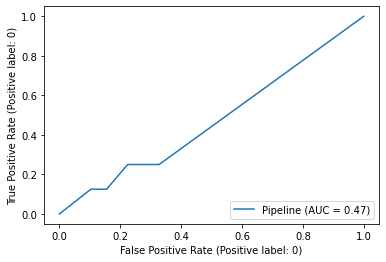

In [7]:
model = DecisionTreeClassifier(random_state=0)

parameter_grid = {'clf__criterion': ['gini', 'entropy'],
            'clf__splitter': ['best', 'random'],
            'clf__max_features': ['sqrt', 'log2'],
            'clf__min_samples_split':  [2, 4, 6, 8],
            'clf__min_samples_leaf':  [1, 2, 4, 6],
            'clf__min_impurity_split': [0.05, 0.1, 0.23, 0.3],
            'clf__class_weight': ["balanced", None]}

dt = grid_search(model, parameter_grid)

## Random Forest

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Best score: 0.8486345598845599
Best parameters: {'clf__criterion': 'gini', 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 200}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 RandomForestClassifier(min_samples_split=5, n_estimators=200,
                                        random_state=0))])

AUC Score:  0.8211206896551725
Confusion matrix:
[[ 4  4]
 [13 45]]

Classification report:
              precision    recall  f1-score   support

           0       0.24      0.50      0.32         8
           1       0.92      0.78      0.84        58

    accuracy                           0.74        66
   macro avg       0.58      0.64      0.58        66
weighted avg       0.84      0.74      0.78        66




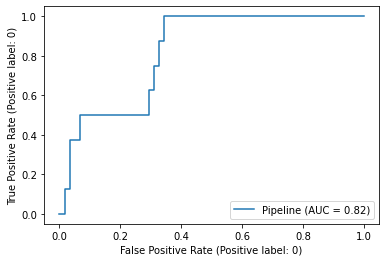

In [8]:
model = RandomForestClassifier(random_state=0)

parameter_grid = {'clf__n_estimators': [100, 150, 200, 250],
                  'clf__criterion': ['gini', 'entropy'],
                  'clf__min_samples_split': [2, 5, 10],
                  'clf__min_samples_leaf': [1, 2, 4],
                  'clf__max_features': ['auto', None]}

rf = grid_search(model, parameter_grid)

## KNN

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best score: 0.7700577200577201
Best parameters: {'clf__algorithm': 'ball_tree', 'clf__n_neighbors': 10, 'clf__weights': 'distance'}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 KNeighborsClassifier(algorithm='ball_tree', n_neighbors=10,
                                      weights='distance'))])

AUC Score:  0.8135775862068966
Confusion matrix:
[[ 6  2]
 [14 44]]

Classification report:
              precision    recall  f1-score   support

           0       0.30      0.75      0.43         8
           1       0.96      0.76      0.85        58

    accuracy                           0.76        66
   macro avg       0.63      0.75      0.64        66
weighted avg       0.88      0.76      0.80        66




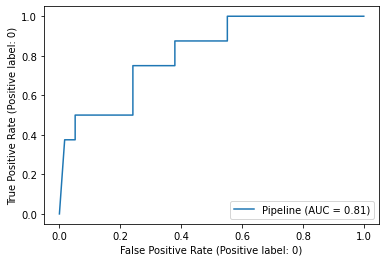

In [9]:
model = KNeighborsClassifier()

parameter_grid = {'clf__n_neighbors': [5, 10, 15],
                  'clf__weights': ['uniform', 'distance'],
                  'clf__algorithm': ['ball_tree', 'kd_tree', 'brute']}

knn = grid_search(model, parameter_grid)

## SVM

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best score: 0.7788979076479076
Best parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'sigmoid'}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 SVC(C=1, kernel='sigmoid', probability=True, random_state=0))])

AUC Score:  0.8469827586206897
Confusion matrix:
[[ 6  2]
 [16 42]]

Classification report:
              precision    recall  f1-score   support

           0       0.27      0.75      0.40         8
           1       0.95      0.72      0.82        58

    accuracy                           0.73        66
   macro avg       0.61      0.74      0.61        66
weighted avg       0.87      0.73      0.77        66




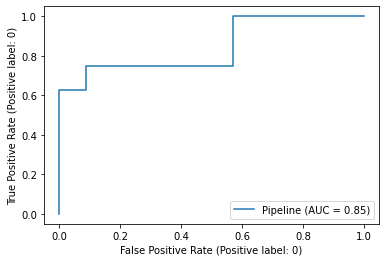

In [10]:
model = SVC(random_state=0, probability=True)

parameter_grid = {'clf__C': [0.1, 1, 10, 100],
              'clf__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'clf__gamma': ['scale', 'auto']}

svm = grid_search(model, parameter_grid)

## AdaBoost


Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best score: 0.7455158730158729
Best parameters: {'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 AdaBoostClassifier(learning_rate=0.3, n_estimators=100,
                                    random_state=0))])

AUC Score:  0.7068965517241379
Confusion matrix:
[[ 2  6]
 [ 4 54]]

Classification report:
              precision    recall  f1-score   support

           0       0.33      0.25      0.29         8
           1       0.90      0.93      0.92        58

    accuracy                           0.85        66
   macro avg       0.62      0.59      0.60        66
weighted avg       0.83      0.85      0.84        66




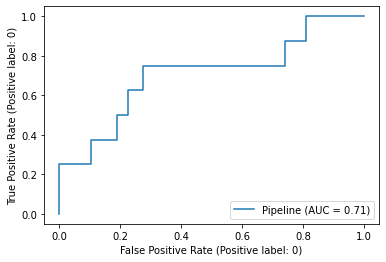

In [11]:
model = AdaBoostClassifier(random_state=0)

parameter_grid = {'clf__n_estimators': [50, 100, 150],
                  'clf__learning_rate': [0.3, 0.5, 1.0]}

ada = grid_search(model, parameter_grid)

## GradientBoost

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


C:\Users\fmna\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.77965729 0.7606728  0.76609848 0.78127886 0.76873016 0.78489719
 0.78096681 0.7737987  0.78907468 0.78150072 0.77891955 0.78046537
 0.79349387 0.77262446 0.77657648 0.77609488 0.76794553 0.76441558
 0.79216089 0.7838943  0.78337662 0.79216089 0.7838943  0.78337662
 0.79565296 0.78505952 0.78152597 0.77965729 0.7606728  0.76609848
 0.78127886 0.76873016 0.78489719 0.78096681 0.7737987  0.78907468
 0.78150072 0.77891955 0.78046537 0.79349387 0.77262446 0.77657648
 0.77609488 0.76794553 0.76441558 0.79216089 0.7838943  0.78337662
 0.79216089 0.7838943  0.78337662 0.79565296 0.78505952 0.78152597
 0.75882576 0.77216089 0.7828373  0.75263528 0.75991703 0.76767857
 0.75376804 0.76430736 0.77874459 0.78210678 0.78919553 0.79956349
 0.765193   0.78863636 0.79519481 0.77764069 0.77525613 0.78222403
 0.79289322 0.7812518  0.79347403 0.79289322 0.7812518


Best score: 0.8280952380952382
Best parameters: {'clf__criterion': 'friedman_mse', 'clf__learning_rate': 1.0, 'clf__max_features': 'auto', 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 150}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 GradientBoostingClassifier(learning_rate=1.0,
                                            max_features='auto',
                                            min_samples_split=5,
                                            n_estimators=150,
                                            random_state=0))])

AUC Score:  0.8038793103448276
Confusion matrix:
[[ 4  4]
 [ 9 49]]

Classification report:
              precision    recall  f1-score   support

           0       0.31      0.50      0.38         8
           1       0.92      0.84      0.88        58

    accuracy                           0.80        66
   macro avg       0.62      0.67      0.63        66
weig

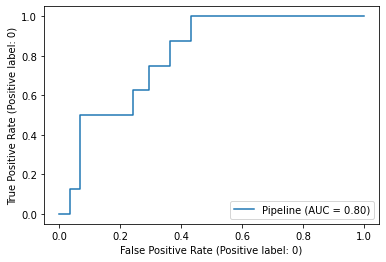

In [12]:
model = GradientBoostingClassifier(random_state=0)

parameter_grid = {'clf__n_estimators': [50, 100, 150],
                  'clf__learning_rate': [0.2, 0.3, 0.5, 1.0],
                  'clf__criterion': ['friedman_mse', 'squared_error'],
                  'clf__min_samples_split': [2, 5, 10],
                  'clf__min_samples_leaf': [1, 2, 4],
                  'clf__max_features': ['auto', None]}

gb = grid_search(model, parameter_grid)

## XGBoost

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best score: 0.8225829725829726
Best parameters: {'clf__alpha': 0, 'clf__gamma': 0.1, 'clf__learning_rate': 0.3, 'clf__n_estimators': 100}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 XGBClassifier(alpha=0, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='auc', gamma=0.1,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='', learning_rate=0.3,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=12, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1

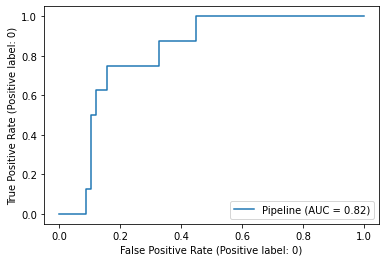

In [13]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='auc')

parameter_grid = {
    'clf__learning_rate': [0.2, 0.3, 0.5, 1.0],
    'clf__alpha': [0, 0.01, 0.1],
    'clf__n_estimators': [100, 200, 300],
    'clf__gamma': [0, 0.01, 0.1]
}

xgb = grid_search(model, parameter_grid)

## MLP

Fitting 5 folds for each of 25 candidates, totalling 125 fits


C:\Users\fmna\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(



Best score: 0.799810606060606
Best parameters: {'clf__alpha': 0.85, 'clf__hidden_layer_sizes': 10}
Best estimator: Pipeline(steps=[('smote', SMOTE(random_state=0)),
                ('clf',
                 MLPClassifier(alpha=0.85, hidden_layer_sizes=10,
                               random_state=0))])

AUC Score:  0.877155172413793
Confusion matrix:
[[ 6  2]
 [11 47]]

Classification report:
              precision    recall  f1-score   support

           0       0.35      0.75      0.48         8
           1       0.96      0.81      0.88        58

    accuracy                           0.80        66
   macro avg       0.66      0.78      0.68        66
weighted avg       0.89      0.80      0.83        66




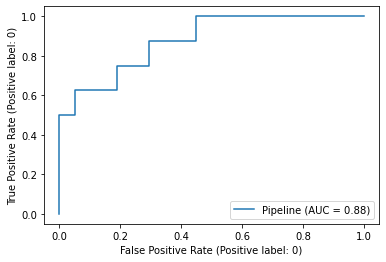

In [17]:
model = MLPClassifier(alpha=1, hidden_layer_sizes=150, random_state=0)

parameter_grid = {'clf__alpha': [0.1, 0.25, 0.5, 0.75, 0.85],
                    'clf__hidden_layer_sizes': [10, 20, 30, 60, 100],
                    
                    }

mlp = grid_search(model, parameter_grid)

# Predictions

In [22]:
x_real = test_data[features]

# change according to model
predictions = rf['clf'].predict_proba(x_real)[:, -1]

submission = pd.DataFrame()
submission['Id'] = test_data['loan_id']
submission['Predicted'] = predictions

submission.to_csv(date.today().strftime("%d-%m-%Y") + '.csv', index=False)

submission

,Id,Predicted
0,4962,0.746863
1,4967,0.569321
2,4968,0.746863
3,4986,0.746863
4,4988,0.774815
...,...,...
349,7279,0.746863
350,7286,0.782315
351,7292,0.782315
352,7294,0.782315
